Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - bbox_output_loss: 141.2843 - bbox_output_mse: 141.2843 - digit_output_accuracy: 0.1030 - digit_output_loss: 3.3251 - loss: 144.6094 - val_bbox_output_loss: 70.8148 - val_bbox_output_mse: 69.8809 - val_digit_output_accuracy: 0.1050 - val_digit_output_loss: 2.6820 - val_loss: 72.5938
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - bbox_output_loss: 68.1788 - bbox_output_mse: 68.1788 - digit_output_accuracy: 0.1143 - digit_output_loss: 2.5090 - loss: 70.6878 - val_bbox_output_loss: 66.7145 - val_bbox_output_mse: 66.2113 - val_digit_output_accuracy: 0.1025 - val_digit_output_loss: 2.4249 - val_loss: 68.6233
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - bbox_output_loss: 67.5550 - bbox_output_mse: 67.5550 - digit_output_accuracy: 0.0912 - digit_output_loss: 2.3609 - loss: 69.9159 - val_bbox_output_loss: 67.8000 - val_bbox_output_mse: 67.0805 - val_digit_output_accuracy: 0.0700 - val_digit_output_loss: 2.3213 - val_loss: 69.400

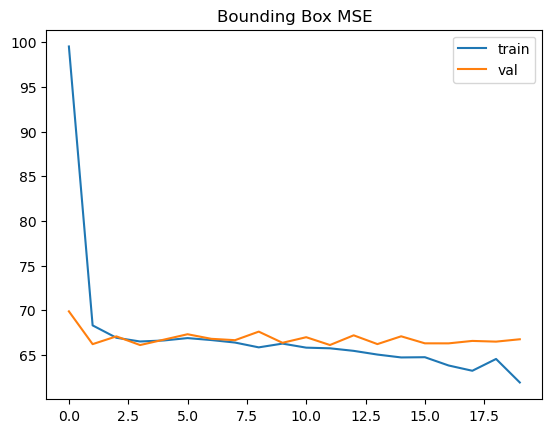

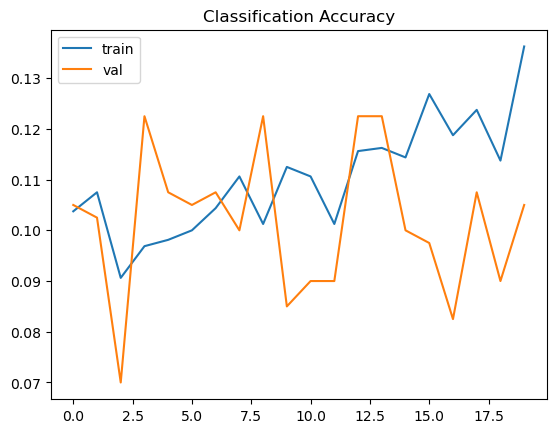

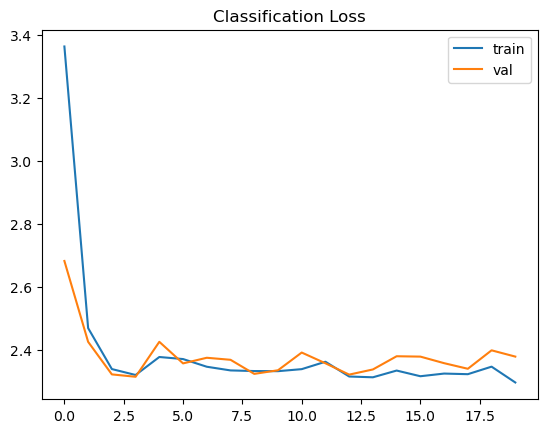

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


TypeError: display_digits_with_boxes() missing 1 required positional argument: 'title'

In [1]:
# Object Detection using CNN - Jupyter Notebook Version

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# --- Simulated Dataset Creation ---
def generate_data(num_samples=1000):
    digits = np.random.randint(0, 10, size=num_samples)
    images = np.random.rand(num_samples, 28, 28, 1)  # Simulated 28x28 grayscale images
    labels = tf.keras.utils.to_categorical(digits, num_classes=10)
    bboxes = np.random.rand(num_samples, 4) * 28  # xmin, ymin, xmax, ymax
    return images, labels, bboxes

images, labels, bboxes = generate_data(2000)
train_imgs, val_imgs, train_labels, val_labels, train_bboxes, val_bboxes = train_test_split(
    images, labels, bboxes, test_size=0.2, random_state=42)

# --- Model Definition ---
def build_model():
    input_layer = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    classifier = layers.Dense(10, activation='softmax', name='digit_output')(x)
    bbox_regressor = layers.Dense(4, name='bbox_output')(x)

    model = models.Model(inputs=input_layer, outputs=[classifier, bbox_regressor])
    return model

model = build_model()
model.compile(
    optimizer='adam',
    loss={'digit_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
    metrics={'digit_output': 'accuracy', 'bbox_output': 'mse'}
)

# --- Model Training ---
history = model.fit(
    train_imgs,
    {'digit_output': train_labels, 'bbox_output': train_bboxes},
    validation_data=(val_imgs, {'digit_output': val_labels, 'bbox_output': val_bboxes}),
    epochs=20,
    batch_size=64
)

# --- Plotting Metrics ---
def plot_metrics(metric, title):
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history['val_' + metric], label='val')
    plt.title(title)
    plt.legend()
    plt.show()

plot_metrics('bbox_output_mse', 'Bounding Box MSE')
plot_metrics('digit_output_accuracy', 'Classification Accuracy')
plot_metrics('digit_output_loss', 'Classification Loss')

# --- Intersection over Union ---
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)

    smoothing = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    overlap_width = np.maximum(0, xmax_overlap - xmin_overlap)
    overlap_height = np.maximum(0, ymax_overlap - ymin_overlap)
    overlap_area = overlap_width * overlap_height

    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    union_area = pred_area + true_area - overlap_area
    iou = (overlap_area + smoothing) / (union_area + smoothing)

    return iou

# --- Visualization ---
def display_digits_with_boxes(images, labels, pred_labels, true_labels, pred_boxes, true_boxes, iou, title):
    plt.figure(figsize=(12, 3))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        img = images[i].squeeze()
        ax.imshow(img, cmap='gray')

        # Draw predicted box
        box = pred_boxes[i]
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], edgecolor='r', facecolor='none'))
        ax.set_title(f"{np.argmax(pred_labels[i])} ({np.argmax(true_labels[i])})")
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# --- Prediction and Evaluation ---
prediction = model.predict(val_imgs, batch_size=64)
predicted_labels = prediction[0]
predicted_bboxes = prediction[1]

ious = intersection_over_union(predicted_bboxes, val_bboxes)

display_digits_with_boxes(val_imgs, predicted_labels, val_labels,
                          predicted_bboxes, val_bboxes, ious, "Predicted vs Actual")
